In [25]:
import geopandas as gpd
import numpy as np
import shapely
import geofileops as gfo
import tempfile
from pathlib import Path
import matplotlib.pyplot as plt
import logging

logging.basicConfig(level=logging.ERROR)

In [26]:
N_SQUARES = 40
SQUARE_WIDTH = 0.1
N_CLASSES = 4

In [27]:
def geofileops_overlay(
    left_df, right_df, input1_columns_prefix="l1_", input2_columns_prefix="l2_"
):
    temp_folder = tempfile.TemporaryDirectory()
    left_df_file = str(Path(temp_folder.name, "left.gpkg"))
    right_df_file = str(Path(temp_folder.name, "right.gpkg"))
    union_file = str(Path(temp_folder.name, "union.gpkg"))

    left_df.to_file(left_df_file)
    right_df.to_file(right_df_file)

    # This performs the same operation as geopandas overlay(how="union")
    gfo.union(
        input1_path=left_df_file,
        input2_path=right_df_file,
        output_path=union_file,
        input1_columns_prefix=input1_columns_prefix,
        input2_columns_prefix=input2_columns_prefix,
    )
    overlay_data = gpd.read_file(union_file)

    return overlay_data


def geofileops_dissolve(df, groupby_columns=None):
    # Create a temporary folder to save intermediate results on disk to
    temp_folder = tempfile.TemporaryDirectory()
    input_path = Path(temp_folder.name, "input.gpkg")
    output_path = Path(temp_folder.name, "output.gpkg")

    # Write the input data to disk
    df.to_file(input_path)
    # Dissolve
    gfo.dissolve(
        input_path=input_path,
        output_path=output_path,
        explodecollections=False,
        groupby_columns=groupby_columns,
    )

    # Read the result and return
    dissolved = gpd.read_file(output_path)
    return dissolved


def merge_classified_polygons(
    classified_polygons: gpd.GeoDataFrame,
    class_column: str,
    print_tiebreaking_stats: bool = False,
) -> gpd.GeoDataFrame:
    """
    Take multiple potentially-overlapping polygons with associated class information and merge them
    into non-overlapping classified polygons using the following strategy.
    * For each location, compute the number of polygons that cast votes for each class
    * For any regions that have a non-tied number of votes, set the output class to the majority vote
    * For any regions with tied votes, break ties in favor of the less common class (based on un-ambigous regions)

    Args:
        classified_polygons (gpd.GeoDataFram): A geodataframe containing the `class_column` column
        class_column (str): The column to use as the class
        print_tiebreaking_stats (bool, optional): Print the fraction of area that needed to be tiebroken
    """
    # Create a dictionary where the keys are the classes and the values are the dataframe with all
    # the (multi)polygons corresponding to that class
    grouped_by_class = {k[0]: v for k, v in classified_polygons.groupby([class_column])}
    unique_classes = list(grouped_by_class.keys())

    # Now, for each individual class, compute how many overlapping polygons there are for each
    # location. This information will be used in future steps to prioritize that class if there are
    # multiple predictions for the same location.
    n_overlapping_per_class = []
    for cls, geometries_per_class in grouped_by_class.items():
        # Create a new column for counts that is all ones
        geometries_per_class["counts"] = 1
        # Only retain the geometry column and the counts
        geometries_per_class = geometries_per_class[["geometry", "counts"]]

        # Initialize the number overlapping to the first geometry, which has a count of 1
        n_overlapping = geometries_per_class.iloc[0:1]
        # Iterate over the subsequent geometries
        for i in range(1, len(geometries_per_class)):
            geometry = geometries_per_class[i : i + 1]
            # Overlay the running total of overlaps with the new geometry
            n_overlapping = geofileops_overlay(n_overlapping, geometry)
            # Since we use the union approach, there will be some nan values for counts where one
            # side of the overlay did not overlap the other one. Set these to zero.
            n_overlapping.fillna(0, inplace=True)
            # Add the counts from the left and right dataframe and set them to a new "counts" column
            n_overlapping["counts"] = (
                n_overlapping["l1_counts"] + n_overlapping["l2_counts"]
            )
            # Since we'll be repeating this process, it's important to drop these columns or there
            # will be a name collision on the next iteration
            n_overlapping.drop(["l1_counts", "l2_counts"], axis=1, inplace=True)

        # TODO, consider whether it would be more efficient to dissolve after every operation. It
        # would be an additional step, but it could speed up the overlay
        n_overlapping = geofileops_dissolve(n_overlapping, groupby_columns="counts")
        # Rename the counts column to the name of the class
        n_overlapping.rename(columns={"counts": str(cls)}, inplace=True)
        # Append to the running list
        n_overlapping_per_class.append(n_overlapping)

    # Overlay the votes for each class to get all the regions with distinct combinations of votes
    votes_per_class = n_overlapping_per_class[0]
    for single_class_overlay in n_overlapping_per_class[1:]:
        votes_per_class = geofileops_overlay(
            votes_per_class,
            single_class_overlay,
            input1_columns_prefix="",
            input2_columns_prefix="",
        )

    # Similar to before, since we're doing a "union" overlay, there will be rows that don't have
    # values for all columns. Fill them in with zero.
    votes_per_class.fillna(0, inplace=True)

    unique_classes_as_strs = [str(x) for x in unique_classes]
    # Extract the counts columns to a numpy array and find the most common class per row
    class_counts_matrix = votes_per_class[unique_classes_as_strs].values
    max_class_counts = np.max(class_counts_matrix, axis=1, keepdims=True)

    # Find rows where one class has the most votes (there are no ties)
    one_max_class = np.sum(max_class_counts == class_counts_matrix, axis=1) == 1

    # Extract rows where one class has the most votes
    rows_with_one_class = votes_per_class.iloc[one_max_class]
    # Label them with the max class
    rows_with_one_class["max_class"] = rows_with_one_class[
        unique_classes_as_strs
    ].idxmax(axis=1)
    # Dissolve all polygons so we have one (multi)polygon per class
    rows_with_one_class = geofileops_dissolve(rows_with_one_class, groupby_columns="max_class")

    # Compute the area of each
    rows_with_one_class["area"] = rows_with_one_class.area

    # Order the classes from smallest area to largest, based on unambigous regions
    sorted_inds = (rows_with_one_class["area"]).argsort()
    sorted_classes = rows_with_one_class["max_class"][sorted_inds].tolist()

    if print_tiebreaking_stats:
        area_of_sorted = geofileops_dissolve(rows_with_one_class).area[0]
        total_area = geofileops_dissolve(votes_per_class).area[0]

        print(
            f"Ties had to be broken for {(100 *(1 - (area_of_sorted/total_area))):.1f}% of the total predictions"
        )

    # Determine which classes (if any) have no non-overlapping regions. Add them to the start of the
    # list
    zero_area_classes = [c for c in unique_classes_as_strs if c not in sorted_classes]
    # Prepend the classes to the beginning of the list of sorted classes
    sorted_classes = zero_area_classes + sorted_classes

    # Reorder the columns starting with the rarest class. Then compute the index of the max value.
    # Since this returns the first instance of the maximum value, ties will be broken in favor of
    # the class that had the least area in the unambigious region.
    max_class = votes_per_class[sorted_classes].idxmax(axis=1)
    # Create a new column for the max class
    votes_per_class["max_class"] = max_class
    votes_per_class = votes_per_class[["max_class", "geometry"]]
    # Dissolve so there's only one (multi)polygon per class
    votes_per_class = geofileops_dissolve(votes_per_class, groupby_columns="max_class")
    return votes_per_class

Create dummy data

<Axes: >

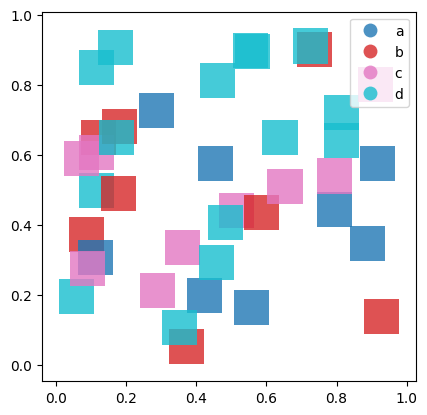

In [28]:
tl_corners = np.random.random((N_SQUARES, 2)) * (1 - SQUARE_WIDTH)
boxes = [shapely.box(tl[0], tl[1], tl[0] + SQUARE_WIDTH, tl[1] + SQUARE_WIDTH) for tl in tl_corners]
classes = np.random.randint(0, N_CLASSES, size=N_SQUARES)
classes = np.array(["abcd"[i] for i in classes])

classified_polygons = gpd.GeoDataFrame({"geometry": boxes, "classes": classes}, crs=3311)
classified_polygons.plot("classes",alpha=0.8, cmap="tab10", legend=True)

/home/exouser/miniconda3/envs/geofileops/lib/python3.10/site-packages/geopandas/geodataframe.py:1819: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


Ties had to be broken for 12.3% of the total predictions


,max_class,geometry
0,d,"MULTIPOLYGON (((0.402 0.101, 0.323 0.101, 0.32..."
1,b,"MULTIPOLYGON (((0.423 0.101, 0.423 0.001, 0.32..."
2,c,"MULTIPOLYGON (((0.338 0.264, 0.338 0.164, 0.23..."
3,a,"MULTIPOLYGON (((0.473 0.249, 0.473 0.241, 0.47..."


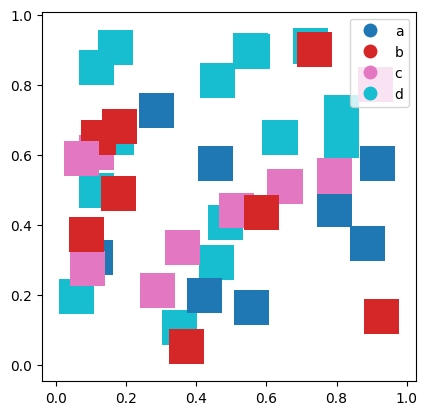

In [29]:
merged = merge_classified_polygons(classified_polygons=classified_polygons, class_column="classes", print_tiebreaking_stats=True)
merged.plot("max_class", cmap="tab10", legend=True)
merged